In [17]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from aquarel import load_theme
import plotly.express as px
import pytensor.tensor as pt

theme = load_theme('minimal_light')
theme.apply()


In [18]:
#################
## Import Data ##
#################

# Import full model dataset
df = pd.read_csv('Data/cfb_2025_model_input.csv')

# Pull each column as a numpy array for use in PyMC
home_idx   = df['home_idx'].to_numpy()
away_idx   = df['away_idx'].to_numpy()
stadium_idx = df['stadium_idx'].to_numpy()
neutral    = df['neutral'].to_numpy()
conf_game  = df['conf_game'].to_numpy()
mismatch_home = df['mismatch_home'].to_numpy()
mismatch_away = df['mismatch_away'].to_numpy()
week_idx = df['week_idx'].to_numpy()
fcs_fcs = df['fcs_fcs'].to_numpy()
home_conf_idx = df['home_conf_idx'].to_numpy()
away_conf_idx = df['away_conf_idx'].to_numpy()

# LHS
y_obs = df[['y_home', 'y_away']].to_numpy()

# Number of teams
n_teams = np.max([home_idx.max(), away_idx.max()]) + 1

# Number of stadiums
n_stadiums = np.max(stadium_idx) + 1

# Number of games
n_games = y_obs.shape[0]

# Number of weeks
n_weeks = np.max(week_idx) + 1
week_rows = [np.where(week_idx == w)[0].astype("int64") for w in range(n_weeks)]

# Number of conferences
n_conferences = np.max([home_conf_idx.max(), away_conf_idx.max()]) + 1


In [19]:
###################################
## Build a Team-Conference Index ##
###################################

def build_team_conf_idx(home_idx, away_idx, home_conf_idx, away_conf_idx, n_teams, default_conf_idx=0):

    # Ensure each index is a NumPy array
    home_idx = np.asarray(home_idx, dtype="int64")
    away_idx = np.asarray(away_idx, dtype="int64")
    home_conf_idx = np.asarray(home_conf_idx, dtype="int64")
    away_conf_idx = np.asarray(away_conf_idx, dtype="int64")

    # Preallocate space for the team-conference identifier
    team_conf = np.full(n_teams, default_conf_idx, dtype="int64")

    # All teams
    teams = np.concatenate([home_idx, away_idx])

    # All conferences
    confs = np.concatenate([home_conf_idx, away_conf_idx])

    # Put into a dataframe together
    df_tc = pd.DataFrame({'team': teams, 'conf': confs})

    # Sort
    mode_conf = df_tc.groupby('team')['conf'].agg(lambda s: s.value_counts().idxmax())
    team_conf[mode_conf.index.to_numpy(dtype='int64')] = mode_conf.to_numpy(dtype='int64')

    return team_conf

# In case we are missing a conference for a team (should be filtered out in data prep)
default_conf_idx = int(home_conf_idx.min())

# Assign team-conference indices
team_conf_idx = build_team_conf_idx(home_idx, away_idx, home_conf_idx, away_conf_idx, n_teams, default_conf_idx)


In [20]:
##########################
## Construct PyMC Model ##
##########################

# Set-up tracking of dimensions in PyMC output
coords = {'team': np.arange(n_teams),
          'stadium': np.arange(n_stadiums),
          'game': np.arange(n_games),
          'conf': np.arange(n_conferences),
          'week': np.arange(n_weeks),
          'week_innov': np.arange(n_weeks - 1),
          'side_row': ['home', 'away'],
          'side_col': ['home', 'away']
          }

with (pm.Model(coords=coords) as model):

    # Set prior on the constant (i.e. conditional average points each team scores -- centered at 19 points)
    alpha = pm.Normal('alpha', mu=np.log(19.0), sigma=0.5)

    # Set prior on dummy for whether the game is an in-conference game
    beta_c = pm.Normal('beta_c', mu=0.0, sigma=0.2)

    ### Offense ###

    # Offensive power dispersion for conference and team
    sigma_o_conf = pm.HalfNormal('sigma_o_conf', sigma=0.05)
    sigma_o_team = pm.HalfNormal('sigma_o_team', sigma=0.1)

    # Offensive means for conference and team
    o_conf_raw = pm.Normal('o_conf_raw', mu=0.0, sigma=sigma_o_conf, dims='conf')
    o_team_raw = pm.Normal('o_team_raw', mu=0.0, sigma=sigma_o_team, dims='team')

    # Each team's offensive power
    o_raw = o_conf_raw[team_conf_idx] + o_team_raw
    o = pm.Deterministic('o', o_raw - pm.math.mean(o_raw), dims='team')


    ### Defense ###

    # Defensive strength dispersion for conference and team
    sigma_d_conf = pm.HalfNormal('sigma_d_conf', sigma=0.05)
    sigma_d_team = pm.HalfNormal('sigma_d_team', sigma=0.1)

    # Defensive means for conference and team
    d_conf_raw = pm.Normal('d_conf_raw', mu=0.0, sigma=sigma_d_conf, dims='conf')
    d_team_raw = pm.Normal('d_team_raw', mu=0.0, sigma=sigma_d_team, dims='team')

    # Each team's defensive strength
    d_raw = d_conf_raw[team_conf_idx] + d_team_raw
    d = pm.Deterministic('d', d_raw - pm.math.mean(d_raw), dims='team')

    ### Stadium ###

    # Stadium brutality dispersion (keep closer to zero than offense/defense)
    sigma_s = pm.HalfNormal('sigma_s', sigma=0.2)

    # Mean stadium brutality
    s_mu = pm.Normal('s_mu', mu=0.0, sigma=0.2)

    # Now we sample from a distribution with some mean stadium brutality and some dispersion
    z_s = pm.Normal('z_s', mu=0.0, sigma=1.0, dims='stadium')
    s = pm.Deterministic('s', s_mu + sigma_s * z_s, dims='stadium')

    ### FCS Mismatch ###

    # Prior on the mismatch between FCS and FBS teams
    beta_mismatch = pm.Normal('beta_mismatch', mu=0.0, sigma=0.4)

    # beta_fcs = pm.Normal('beta_fcs', mu=0.0, sigma=0.4)

    ### Build Mean Predicted Home and Away Scores ###
    A = pm.HalfNormal("A_strength", sigma=0.05)

    # Home scores
    mu_home = alpha + A * pt.tanh((o[home_idx] - d[away_idx])/A) + s[stadium_idx] * (1 - neutral) + beta_c * conf_game + beta_mismatch * mismatch_home #+ beta_fcs * fcs_fcs

    # Away scores
    mu_away = alpha + A*pt.tanh((o[away_idx] - d[home_idx])/A) + beta_c * conf_game + beta_mismatch * mismatch_away
    #+ beta_fcs * fcs_fcs

    # Transform log means
    lam_h0 = pm.math.exp(mu_home)
    lam_a0 = pm.math.exp(mu_away)

    # Compute home and away scores
    mu_h = pm.Deterministic('mu_h', pm.math.exp(mu_home), dims='game')
    mu_a = pm.Deterministic('mu_a', pm.math.exp(mu_away), dims='game')

    # Negative Binomial for home and away point distributions
    alpha_h = pm.Exponential('alpha_home', lam=0.05)
    home = pm.NegativeBinomial('home_points', mu=lam_h0, alpha=alpha_h, observed=y_obs[:,0], dims='game')
    alpha_a = pm.Exponential('alpha_away', lam=0.05)
    away = pm.NegativeBinomial('away_points', mu=lam_a0, alpha = alpha_a, observed=y_obs[:,1], dims='game')



In [21]:
####################
## Estimate Model ##
####################

with model:
    trace = pm.sample(draws=2000, tune=2000, chains=4, cores=1, target_accept=0.975, random_seed=0, nuts_sampler='numpyro')



Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]


  0%|          | 0/4000 [00:00<?, ?it/s]


Running chain 1:   0%|          | 0/4000 [00:02<?, ?it/s]

Running chain 2:   0%|          | 0/4000 [00:02<?, ?it/s]


Running chain 3:   0%|          | 0/4000 [00:02<?, ?it/s]

Running chain 1:   5%|▌         | 200/4000 [00:12<03:06, 20.42it/s]


Running chain 0:  10%|█         | 400/4000 [00:13<01:29, 40.27it/s]

Running chain 1:  10%|█         | 400/4000 [00:13<01:30, 39.75it/s]


Running chain 3:  10%|█         | 400/4000 [00:14<01:38, 36.61it/s]

Running chain 1:  15%|█▌        | 600/4000 [00:15<01:00, 56.62it/s]


Running chain 3:  15%|█▌        | 600/4000 [00:16<01:02, 54.05it/s]

Running chain 1:  20%|██        | 800/4000 [00:17<00:44, 71.14it/s]


Running chain 3:  20%|██        | 800/4000 [00:18<00:46, 68.56it/s]

Running chain 1:  25%|██▌       | 1000/4000 [00:19<00:36, 82.04it/s]

In [22]:
###################################
## Take Draws from the Posterior ##
###################################

# Combine chains and draws dimensions
def _flatten_posterior(trace, varname):

    # Take the values from the posterior
    x = trace.posterior[varname].values

    # Extract shapes of number of chains and number of draws
    c, d = x.shape[:2]

    # Reshape first axis into total draws only
    out = x.reshape(c * d, *x.shape[2:])

    return out

# Function to simulate scores
def simulate_scores_from_total_split(trace, n_ppc=2000, seed=0):

    # Set seed
    rng = np.random.default_rng(seed)

    # Pull total score
    mu_h = _flatten_posterior(trace, "mu_h")
    mu_a = _flatten_posterior(trace, "mu_a")

    # Pull proportion of points scored by home
    # p_home   = _flatten_posterior(trace, "p_home")

    # Pull Negative Binomial shape parameter
    alpha_h  = _flatten_posterior(trace, "alpha_home")
    alpha_a  = _flatten_posterior(trace, "alpha_away")

    # if alpha_T.ndim > 1:
    #     alpha_T = alpha_T.reshape(alpha_T.shape[0])

    # Pull random indices
    S = mu_h.shape[0]
    n = min(n_ppc, S)
    idx = rng.choice(S, size=n, replace=False)

    # Pull the means for those random indices
    muh = mu_h[idx]
    mua = mu_a[idx]

    # Pull the home proportions for those random indices
    # p  = p_home[idx]

    # Pull the shape parameters for those random indices
    a_h  = alpha_h[idx][:, None]
    a_a = alpha_a[idx][:, None]

    # The Negative Binomial is the same as a Gamma-Poisson distribution where
    lam = rng.gamma(shape=a_h, scale=muh / a_h)          # Draw lambda from the Gamma distribution
    home = rng.poisson(lam=lam).astype(int)        # Draw total points from the Poisson distribution

    lam_a = rng.gamma(shape=a_a, scale=mua / a_a)
    away = rng.poisson(lam=lam_a).astype(int)

    # Draw the home proportion of points
    # home = rng.binomial(n=total, p=np.clip(p, 1e-8, 1 - 1e-8)).astype(int)


    # Calculate the implied away total
    # away = (total - home).astype(int)
    total = home + away

    return home, away


In [23]:
#################
## Diagnostics ##
#################

# Function to calculate whether the model includes the true value (level)% of the time
def interval_coverage(draws, obs, levels=(0.50, 0.80, 0.95)):

    # Ensure model draws are NumPy arrays
    draws = np.asarray(draws)

    # Ensure empirical observations are NumPy arrays
    obs = np.asarray(obs)

    # Preallocate space for results
    out = []

    # For each level
    for lev in levels:

        # Lower end of bin
        lo = np.quantile(draws, (1 - lev) / 2, axis=0)

        # Upper end of bin
        hi = np.quantile(draws, 1 - (1 - lev) / 2, axis=0)

        # Does the bin include the observed outcome? Take the mean over all observations
        cover = ((obs >= lo) & (obs <= hi)).mean()

        # Append to results
        out.append((lev, cover, obs.size))

    return pd.DataFrame(out, columns=['level', 'coverage', 'n'])


# Check whether (level)% of outcomes are in the model's (level) percentile
def randomized_pit(draws, obs, seed=0):

    # Set random seed
    rng = np.random.default_rng(seed)

    # Ensure model draws are NumPy arrays
    draws = np.asarray(draws)

    # Ensure empirical observations are NumPy arrays
    obs = np.asarray(obs)

    # What is the probability that the model draws are less than the observed value?
    less = (draws < obs[None, :]).mean(axis=0)

    # How often are the model draws equal to the ovserved value?
    eq = (draws == obs[None, :]).mean(axis=0)

    # Take random normal draws
    u = rng.random(obs.size)

    # Include a small jitter around equal draws
    pit = less + u * eq

    return pit

# Check model performance on (1) spread and (2) total points scored
def score_diagnostics(trace, y_obs_pts, n_ppc=2000, seed=0, levels=(0.50, 0.80, 0.95)):

    # Observed points as integers
    y_obs_pts = np.asarray(y_obs_pts).astype(int)

    # Observed home points scored
    home_obs = y_obs_pts[:, 0]

    # Observed away points scored
    away_obs = y_obs_pts[:, 1]

    # Simulate scores from model posterior predictive
    home_rep, away_rep = simulate_scores_from_total_split(trace, n_ppc=n_ppc, seed=seed)

    # Calculate spread from model
    margin_rep = home_rep - away_rep

    # Calculate total from model
    total_rep  = home_rep + away_rep

    # Calculate margin from data
    margin_obs = home_obs - away_obs

    # Calculate total from data
    total_obs  = home_obs + away_obs

    # Does our model cover the spread and total?
    cov_margin = interval_coverage(margin_rep, margin_obs, levels=levels)
    cov_total  = interval_coverage(total_rep, total_obs, levels=levels)

    # Does the model CDF match the data's CDF?
    pit_margin = randomized_pit(margin_rep, margin_obs, seed=seed + 1)
    pit_total  = randomized_pit(total_rep, total_obs, seed=seed + 2)

    # Display PIT summary in a dataframe
    pit_summary = pd.DataFrame([{
        'pit_margin_mean': pit_margin.mean(),
        'pit_margin_std':  pit_margin.std(ddof=0),
        'pit_total_mean':  pit_total.mean(),
        'pit_total_std':   pit_total.std(ddof=0),
    }])

    return cov_margin, cov_total, pit_summary




In [24]:
#####################
## Run Diagnostics ##
#####################

cov_margin, cov_total, pit_summary = score_diagnostics(trace, y_obs_pts=y_obs, n_ppc=2000, seed=0, levels=(0.50, 0.80, 0.95))

print("Margin interval coverage:")
print(cov_margin.to_string(index=False))
print("\nTotal interval coverage:")
print(cov_total.to_string(index=False))
print("\nPIT summary (Uniform(0,1) target: mean~0.5, std~0.288675):")
print(pit_summary.to_string(index=False))

Margin interval coverage:
 level  coverage   n
  0.50  0.624169 902
  0.80  0.898004 902
  0.95  0.984479 902

Total interval coverage:
 level  coverage   n
  0.50  0.651885 902
  0.80  0.916851 902
  0.95  0.993348 902

PIT summary (Uniform(0,1) target: mean~0.5, std~0.288675):
 pit_margin_mean  pit_margin_std  pit_total_mean  pit_total_std
        0.491296        0.251433        0.525807       0.240149


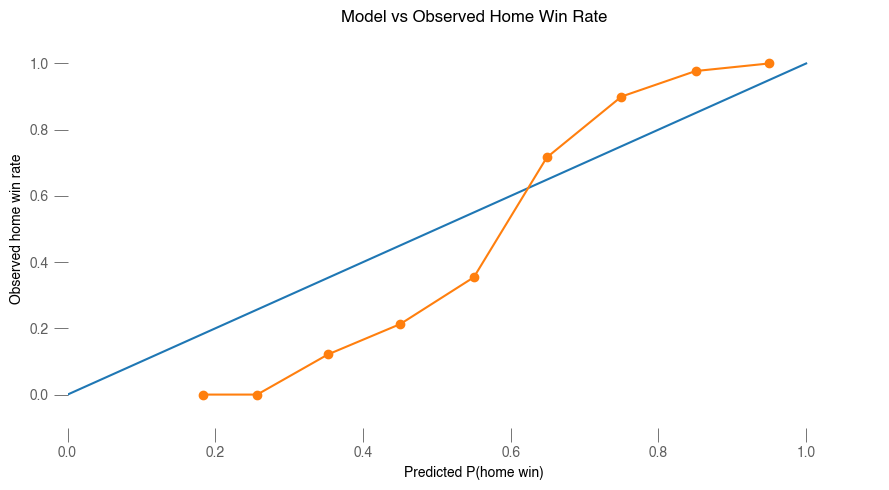

,bin_lo,bin_hi,p_mean,obs_win_rate,n
0,0.1,0.2,0.184000,0.000000,1
1,0.2,0.3,0.256722,0.000000,27
2,0.3,0.4,0.352523,0.121212,66
3,0.4,0.5,0.450454,0.212963,108
4,0.5,0.6,0.550106,0.354331,127
5,0.6,0.7,0.648843,0.716049,162
6,0.7,0.8,0.749982,0.900000,140
7,0.8,0.9,0.850366,0.977099,131
8,0.9,1.0,0.949936,1.000000,140


In [25]:
##########################
## Win Probability Plot ##
##########################

def plot_win_prob(home_rep, away_rep, y_obs, n_bins=10, min_count=1):

    # Ensure model generated point draws are NumPy arrays
    home_rep = np.asarray(home_rep)
    away_rep = np.asarray(away_rep)

    # Ensure observed points is a NumPy array
    y_obs = np.asarray(y_obs)

    # Calculate the probability of winning from the model (how often does home outscore away)
    p_pred = (home_rep > away_rep).mean(axis=0)

    ### Construct reliability table ###

    # Construct bins
    bins = np.linspace(0.0, 1.0, n_bins + 1)

    # Which bin does each game fit into based on the model?
    bin_id = np.clip(np.digitize(p_pred, bins) - 1, 0, n_bins - 1)

    # Preallocate space for each bin
    rows = []

    # For each bin
    for b in range(n_bins):

        # Boolean mask for each game -- does game g fall into bin b?
        m = bin_id == b

        # Count the number of games
        if m.sum() >= min_count:

            # How often does home win when the model gives home an x% chance to win?
            rows.append((bins[b], bins[b + 1],
                         p_pred[m].mean(), y_obs[m].mean(), int(m.sum())))

    # Turn into dataframe
    cal = pd.DataFrame(rows, columns=['bin_lo', 'bin_hi', 'p_mean', 'obs_win_rate', 'n'])


    ### Plot Model vs Empirics ###

    plt.figure(figsize=(9, 5))

    # Plot 45-degree line (ideally model would line up with observed data)
    plt.plot([0, 1], [0, 1])

    # Make sure we have data to plot
    if len(cal) > 0:

        # Plot binned observed win rate vs binned predicted win rate
        plt.plot(cal['p_mean'], cal['obs_win_rate'], marker='o')

    # Axis labels and title
    plt.xlabel('Predicted P(home win)')
    plt.ylabel('Observed home win rate')
    plt.title('Model vs Observed Home Win Rate')

    # Limit axes to 1
    plt.xlim(0, 1.1)
    plt.ylim(-0.1, 1.1)

    plt.tight_layout()

    plt.show()

    return cal

# Set-up observed home and away scores
home_obs = y_obs[:, 0]
away_obs = y_obs[:, 1]

# Simulate model
home_rep, away_rep = simulate_scores_from_total_split(trace, n_ppc=2000, seed=0)

# Calculate observed wins
y_true = (home_obs > away_obs).astype(int)

# Plot visual
plot_win_prob(home_rep, away_rep, y_true)


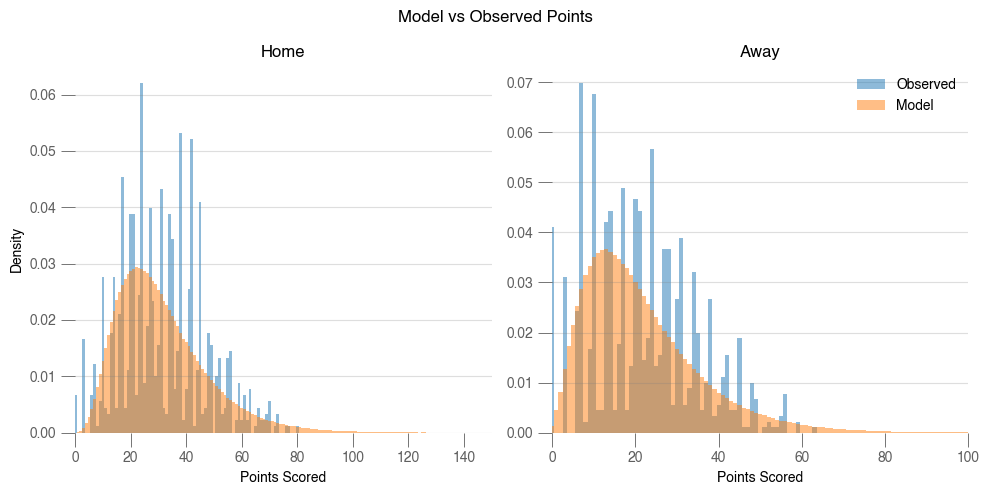

In [26]:
###############################
## Plot Points Distributions ##
###############################

# Function that plots model and observed distributions of points
def plot_points_histograms(home_obs, away_obs, home_rep, away_rep, max_points=None, density=True):

    # Ensure all point vectors are NumPy arrays
    home_obs = np.asarray(home_obs).astype(int)
    away_obs = np.asarray(away_obs).astype(int)
    home_rep = np.asarray(home_rep).astype(int)
    away_rep = np.asarray(away_rep).astype(int)

    # Set maximum points scored
    if max_points is None:
        max_points = int(max(home_obs.max(), away_obs.max(),
                             home_rep.max(), away_rep.max()))

    # Create point bins for the histogram
    bins = np.arange(0, max_points + 2) - 0.5

    home_model = home_rep.reshape(-1)
    away_model = away_rep.reshape(-1)

    plt.figure(figsize=(10, 5))

    ax0 = plt.subplot(1,2,1)
    ax0.hist(home_obs, bins=bins, density=density, alpha=0.5, label='Observed')
    ax0.hist(home_model, bins=bins, density=density, alpha=0.5, label='Model')
    ax0.set_xlabel('Points Scored')
    ax0.set_ylabel('Density' if density else 'Count')
    ax0.set_title('Home')
    ax0.set_xlim([0,150])
    ax0.grid(axis='y', alpha=0.25, color='tab:gray')

    ax1 = plt.subplot(1,2,2)
    ax1.hist(away_obs, bins=bins, density=density, alpha=0.5, label='Observed')
    ax1.hist(away_model, bins=bins, density=density, alpha=0.5, label='Model')
    ax1.set_xlabel('Points Scored')
    ax1.set_title('Away')
    ax1.legend(frameon=False)
    ax1.set_xlim([0,100])
    ax1.grid(axis='y', alpha=0.25, color='tab:gray')

    plt.suptitle('Model vs Observed Points')

    plt.tight_layout()

    plt.show()


plot_points_histograms(home_obs, away_obs, home_rep, away_rep)


In [27]:
#########################
## Plot Power Rankings ##
#########################

# Calculate credible sets
def _central_interval(samples, level=0.68):

    # Ensure power ratings are a NumPy array
    samples = np.asarray(samples)

    # Calculate width of bars
    lo = np.quantile(samples, (1 - level) / 2, axis=0)
    hi = np.quantile(samples, 1 - (1 - level) / 2, axis=0)

    return lo, hi

def plot_cfp_off_def_forest(trace, team_map_df, cfp_team_names=None, level=0.68, sort_by='offense', figsize=None):

    # Token for team_map
    df = team_map_df.copy()

    # Take away spaces and capitalization in team name for easy matching
    df['_name_norm'] = df['team_name'].astype(str).str.strip().str.lower()
    name_norm = pd.Series(cfp_team_names).astype(str).str.strip().str.lower()

    # Pull indices of matching names
    m = df['_name_norm'].isin(set(name_norm))
    df_sel = df[m].copy()

    # Throw error if a team name is not found in the mapping
    found = set(df_sel["_name_norm"])
    missing = [nm for nm in name_norm.tolist() if nm not in found]
    if missing:
        raise ValueError(f"These CFP team names were not found in team_map_df['team_name']: {missing}")

    team_idx = df_sel['team_idx'].to_numpy(dtype=int)
    team_nm  = df_sel['team_name'].astype(str).to_list()

    # Grab posterior samples for offense and defense power rankings for each team
    o_samp = _flatten_posterior(trace, 'o')[:, team_idx]
    d_samp = _flatten_posterior(trace, 'd')[:, team_idx]

    # summaries that MATCH the draws you're using
    off_mean = o_samp.mean(axis=0)
    def_mean = d_samp.mean(axis=0)

    # central credible intervals over draws
    off_lo, off_hi = _central_interval(o_samp, level=level)  # expect returns (team,), (team,)
    def_lo, def_hi = _central_interval(d_samp, level=level)

    # Summarize in a dataframe
    summary = pd.DataFrame({'team': team_nm, 'team_idx': team_idx, 'off_mean': off_mean, 'off_lo': off_lo, 'off_hi': off_hi, 'def_mean': def_mean, 'def_lo': def_lo, 'def_hi': def_hi})

    # Forest plot order (allow offense, defense, or alphabetically by team name)
    if sort_by == 'offense':
        summary = summary.sort_values('off_mean', ascending=False).reset_index(drop=True)
    elif sort_by == 'defense':
        summary = summary.sort_values('def_mean', ascending=False).reset_index(drop=True)
    elif sort_by == 'team':
        summary = summary.sort_values('team').reset_index(drop=True)
    else:
        raise ValueError("sort_by must be one of: 'offense', 'defense', 'team'.")

    # Setup plot
    N = len(summary)
    if figsize is None:
        figsize = (10, max(4, 0.35 * N + 1.5))

    y = np.arange(N)
    fig, ax = plt.subplots(figsize=figsize)

    # Offensive forests
    x = summary['off_mean'].to_numpy()
    xerr = np.vstack([x - summary['off_lo'].to_numpy(), summary['off_hi'].to_numpy() - x])
    ax.errorbar(x, y - 0.12, xerr=xerr, fmt='o', capsize=2,
                label=f'Offense')

    # Defensive forests
    x = summary['def_mean'].to_numpy()
    xerr = np.vstack([x - summary['def_lo'].to_numpy(), summary['def_hi'].to_numpy() - x])
    ax.errorbar(x, y + 0.12, xerr=xerr, fmt='s', capsize=2,
                label=f'Defense')

    ax.axvline(0.0, linewidth=2, color='tab:gray')
    ax.set_yticks(y)
    ax.set_yticklabels(summary["team"].tolist())
    ax.invert_yaxis()
    ax.set_xlabel('Rating (log point scale)')
    ax.set_title('CFP teams: offensive and defensive power')
    ax.legend(frameon=False)

    fig.tight_layout()
    plt.show()

    return summary

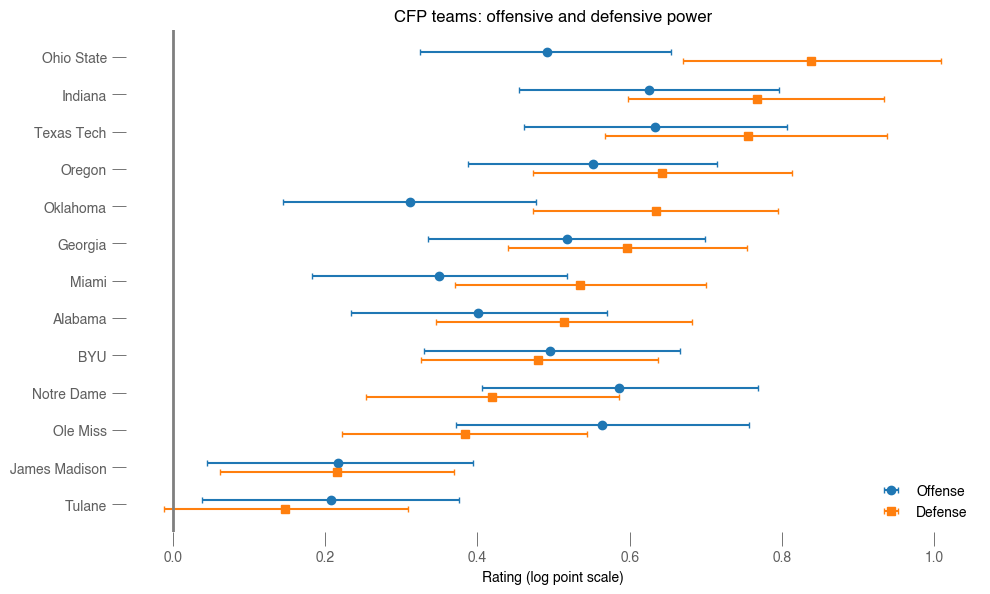

In [28]:
##########################
## Import Team Mappings ##
##########################

team_map_df = pd.read_csv('Data/cfb_2025_team_map.csv')

cfp_teams = ['Georgia', 'Ohio State', 'Indiana', 'Ole Miss', 'Oregon', 'Alabama', 'Oklahoma', 'Texas Tech', 'James Madison', 'Tulane', 'Notre Dame', 'BYU', 'Miami']
cfp_summary = plot_cfp_off_def_forest(trace=trace, team_map_df=team_map_df, cfp_team_names=cfp_teams, level=0.68, sort_by='defense')


In [29]:
###############
## Build CFP ##
###############

def build_cfp_playoff_matchups(
    team_map_df,
    semi_pairs,
    final_home_rule='sf1',
    stadium_idx=0,
    conf_game=0,
):

    # Map team name to index
    name_to_idx = team_map_df.set_index("team_name")["team_idx"].to_dict()

    # Get stadium
    def _get_stadium(game_code):
        if isinstance(stadium_idx, dict):
            return int(stadium_idx.get(game_code, stadium_idx.get("default", 0)))
        return int(stadium_idx)

    # Get whether it is a within conference game
    def _get_conf(game_code):
        if isinstance(conf_game, dict):
            return int(conf_game.get(game_code, conf_game.get("default", 0)))
        return int(conf_game)

    # Semifinals
    rows = []
    for i, (a, b) in enumerate(semi_pairs, start=1):
        if a not in name_to_idx or b not in name_to_idx:
            missing = [t for t in (a, b) if t not in name_to_idx]
            raise ValueError(f"Team(s) not found in team_map_df['team_name']: {missing}")

        game_code = f"SF{i}"
        rows.append({
            'round': 'semifinal',
            'game_code': game_code,
            'home_team': a,
            'away_team': b,
            'home_idx': int(name_to_idx[a]),
            'away_idx': int(name_to_idx[b]),
            'neutral': 1,
            'stadium_idx': _get_stadium(game_code),
            'conf_game': _get_conf(game_code),
            'mismatch_home': 0,
            'mismatch_away': 0,
            'fcs_fcs': 0,
            'scenario': None,
        })

    # Create each possible championship game matchup
    (a, b), (c, d) = semi_pairs
    final_pairs = [(a, c), (a, d), (b, c), (b, d)]

    # Determine how to determine who will be the "home" team
    for (w1, w2) in final_pairs:
        if final_home_rule == 'sf1':
            home_team, away_team = w1, w2
        elif final_home_rule == 'sf2':
            home_team, away_team = w2, w1
        elif final_home_rule == 'lex':
            home_team, away_team = sorted([w1, w2])
        else:
            raise ValueError("final_home_rule must be one of: 'sf1', 'sf2', 'lex'.")

        rows.append({
            'round': 'final',
            'game_code': 'F',
            'home_team': home_team,
            'away_team': away_team,
            'home_idx': int(name_to_idx[home_team]),
            'away_idx': int(name_to_idx[away_team]),
            'neutral': 1,
            'stadium_idx': _get_stadium("F"),
            'conf_game': _get_conf("F"),
            'mismatch_home': 0,
            'mismatch_away': 0,
            'fcs_fcs': 0,
            'scenario': f"SF1_winner={w1}, SF2_winner={w2}",
        })

    return pd.DataFrame(rows)

# Semifinals are set
semi_pairs = [
    ('Indiana', 'Oregon'),   # SF1
    ('Ole Miss', 'Miami'),   # SF2
]

matchups_df = build_cfp_playoff_matchups(
    team_map_df=team_map_df,
    semi_pairs=semi_pairs,
    stadium_idx=0,
    conf_game=0,
)

matchups_df

,round,game_code,home_team,away_team,home_idx,away_idx,neutral,stadium_idx,conf_game,mismatch_home,mismatch_away,fcs_fcs,scenario
0,semifinal,SF1,Indiana,Oregon,90,172,1,0,0,0,0,0,None
1,semifinal,SF2,Ole Miss,Miami,171,126,1,0,0,0,0,0,None
2,final,F,Indiana,Ole Miss,90,171,1,0,0,0,0,0,"SF1_winner=Indiana, SF2_winner=Ole Miss"
3,final,F,Indiana,Miami,90,126,1,0,0,0,0,0,"SF1_winner=Indiana, SF2_winner=Miami"
4,final,F,Oregon,Ole Miss,172,171,1,0,0,0,0,0,"SF1_winner=Oregon, SF2_winner=Ole Miss"
5,final,F,Oregon,Miami,172,126,1,0,0,0,0,0,"SF1_winner=Oregon, SF2_winner=Miami"


In [30]:
##################
## Simulate CFP ##
##################

def simulate_cfp(trace, team_map_df, semi_pairs, n_sims=50000, seed=0, final_home_rule='sf1'):

    # Set random seed
    rng = np.random.default_rng(seed)

    # Reshape parameter draws
    alpha = _flatten_posterior(trace, 'alpha')
    o     = _flatten_posterior(trace, 'o')
    d     = _flatten_posterior(trace, 'd')
    ah    = _flatten_posterior(trace, 'alpha_home')
    aa    = _flatten_posterior(trace, 'alpha_away')
    A     = _flatten_posterior(trace, 'A_strength')
    S = alpha.shape[0]

    # Pick which simulations to pull
    J = rng.integers(0, S, size=n_sims)

    # Find the index of each team
    def resolve_indices(team_map_df, team_or_idx):
        nm = team_or_idx.strip().lower()
        tmp = team_map_df.copy()
        tmp['_nm'] = tmp['team_name'].astype(str).str.strip().str.lower()
        row = tmp.loc[tmp['_nm'] == nm]
        if row.empty:
            raise ValueError(f"team_name '{team_or_idx}' not found in team_map_df['team_name'].")
        team_idx = int(row.iloc[0]['team_idx'])
        team_name = str(row.iloc[0]['team_name'])

        return team_idx, team_name

    # Pair semi-final teams
    (sf1_a, sf1_b), (sf2_c, sf2_d) = semi_pairs

    # Find the indices for each team name
    sf1_a_idx, sf1_a_name = resolve_indices(team_map_df, sf1_a)
    sf1_b_idx, sf1_b_name = resolve_indices(team_map_df, sf1_b)
    sf2_c_idx, sf2_c_name = resolve_indices(team_map_df, sf2_c)
    sf2_d_idx, sf2_d_name = resolve_indices(team_map_df, sf2_d)

    # Simulate any given game
    def _sim_game_fixed(home_idx, away_idx):

        # Mean log scores for home and away (don't need the extra terms -- all zero)
        mu_h = alpha[J] + A[J]*np.tanh((o[J, home_idx] - d[J, away_idx])/A[J])
        mu_a = alpha[J] + A[J]*np.tanh((o[J, away_idx] - d[J, home_idx])/A[J])

        # Transform from log model
        lam_h0 = np.exp(mu_h)
        lam_a0 = np.exp(mu_a)

        # Draw from Negative Binomial distribution (same as Gamma-Poisson)
        lam = rng.gamma(shape=ah[J], scale=lam_h0 / ah[J])
        home = rng.poisson(lam)

        lam_a = rng.gamma(shape=aa[J], scale=lam_a0 / aa[J])
        away = rng.poisson(lam_a)

        total = away + home

        # Random tie-breaker
        ties = (home == away)
        if ties.any():
            coin = rng.random(ties.sum()) < 0.5
            home[ties] = home[ties] + coin.astype(int)
            away[ties] = away[ties] + (~coin).astype(int)

        # Count the number of times home wins
        home_win = (home > away)

        return home, away, home_win


    # Simulate semifinals
    sf1_h, sf1_a, sf1_homewin = _sim_game_fixed(sf1_a_idx, sf1_b_idx)
    sf2_h, sf2_a, sf2_homewin = _sim_game_fixed(sf2_c_idx, sf2_d_idx)

    # Average scores
    sf1_h_mean  = np.mean(sf1_h, axis=0)
    sf1_a_mean = np.mean(sf1_a, axis=0)
    sf2_h_mean = np.mean(sf2_h, axis=0)
    sf2_a_mean = np.mean(sf2_a, axis=0)

    # Note which teams win in each simulation
    sf1_winner_idx = np.where(sf1_homewin, sf1_a_idx, sf1_b_idx)
    sf2_winner_idx = np.where(sf2_homewin, sf2_c_idx, sf2_d_idx)

    if final_home_rule == 'sf1':
        final_home_idx = sf1_winner_idx
        final_away_idx = sf2_winner_idx
    elif final_home_rule == 'sf2':
        final_home_idx = sf2_winner_idx
        final_away_idx = sf1_winner_idx
    elif final_home_rule == 'lex':
        final_home_idx = np.minimum(sf1_winner_idx, sf2_winner_idx)
        final_away_idx = np.maximum(sf1_winner_idx, sf2_winner_idx)
    else:
        raise ValueError("final_home_rule must be one of: 'sf1', 'sf2', 'lex'.")


    ### Finals ###

    # Calculate log-means
    mu_h = alpha[J] + A[J]*np.tanh((o[J, final_home_idx] - d[J, final_away_idx])/A[J])
    mu_a = alpha[J] + A[J]*np.tanh((o[J, final_away_idx] - d[J, final_home_idx])/A[J])

    # Transform from log model
    lam_h0 = np.exp(mu_h)
    lam_a0 = np.exp(mu_a)

    # Draw from Negative Binomial distribution (same as Gamma-Poisson)
    lam = rng.gamma(shape=ah[J], scale=lam_h0 / ah[J])
    home = rng.poisson(lam)

    lam_a = rng.gamma(shape=aa[J], scale=lam_a0 / aa[J])
    away = rng.poisson(lam_a)

    total = home + away

    # Random tie-breaker
    ties = (home == away)
    if ties.any():
        coin = rng.random(ties.sum()) < 0.5
        home[ties] = home[ties] + coin.astype(int)
        away[ties] = away[ties] + (~coin).astype(int)

    # Count the number of times home wins
    final_homewin = (home > away)
    champ_idx = np.where(final_homewin, final_home_idx, final_away_idx)

    ###########################################################################
    # Build Tables
    ###########################################################################

    matchup_probs = pd.DataFrame([
        {
            'round': 'semifinal',                           # Label which round we are looking at
            'game': 'SF1',                                  # Label game
            'team1': sf1_a_name,                            # Which team is home
            'team2': sf1_b_name,                            # Which team is away
            'p_team1_win': sf1_homewin.mean(),              # How often does home win?
            'p_team2_win': 1.0 - sf1_homewin.mean(),        # How often does away win?
            'Team 1 Average Score': sf1_h_mean,             # How much does home score?
            'Team 2 Average Score': sf1_a_mean,             # How much does away score?
        },
        {
            'round': 'semifinal',
            'game': 'SF2',
            'team1': sf2_c_name,
            'team2': sf2_d_name,
            'p_team1_win': sf2_homewin.mean(),
            'p_team2_win': 1.0 - sf2_homewin.mean(),
            'Team 1 Average Score': sf2_h_mean,
            'Team 2 Average Score': sf2_a_mean,
        },
    ])

    # Find which teams we are looking at (from index back to name)
    bracket_team_idx = np.array([sf1_a_idx, sf1_b_idx, sf2_c_idx, sf2_d_idx], dtype=int)
    idx_to_name = dict(zip(team_map_df['team_idx'].astype(int), team_map_df['team_name'].astype(str)))

    # Find probability of winning semifinal
    p_win_sf = {}

    # For each team, initialize probability at zero
    for t in bracket_team_idx:
        p_win_sf[t] = 0.0
    p_win_sf[sf1_a_idx] = (sf1_winner_idx == sf1_a_idx).mean()
    p_win_sf[sf1_b_idx] = (sf1_winner_idx == sf1_b_idx).mean()
    p_win_sf[sf2_c_idx] = (sf2_winner_idx == sf2_c_idx).mean()
    p_win_sf[sf2_d_idx] = (sf2_winner_idx == sf2_d_idx).mean()

    # Probability of winning it all for each team
    p_title = {t: (champ_idx == t).mean() for t in bracket_team_idx}

    # Probability of reaching the final is equal to winning the semifinal game
    p_reach = p_win_sf

    # Given a team reaches the final, what is the probability that team wins it all?
    p_win_final_given_reach = {}
    for t in bracket_team_idx:
        denom = p_reach[t]
        p_win_final_given_reach[t] = (p_title[t] / denom) if denom > 0 else np.nan

    # Put in dataframe
    team_probs = pd.DataFrame([{
        'team': idx_to_name.get(int(t), str(t)),
        'team_idx': int(t),
        'p_win_semifinal': float(p_win_sf[t]),
        'p_reach_final': float(p_reach[t]),
        'p_win_title': float(p_title[t]),
        'p_win_final_given_reach': float(p_win_final_given_reach[t]) if np.isfinite(p_win_final_given_reach[t]) else np.nan,
    } for t in bracket_team_idx]).sort_values('p_win_title', ascending=False).reset_index(drop=True)

    def summarize_playoff_paths(sf1_winner_idx, sf2_winner_idx, champ_idx, idx_to_name):
        n = len(champ_idx)

        # Probability of each final matchup (SF1 winner vs SF2 winner)
        final_match = (
            pd.DataFrame({'sf1': sf1_winner_idx, 'sf2': sf2_winner_idx})
            .value_counts()
            .rename('count')
            .reset_index()
        )
        final_match['p_final'] = final_match['count'] / n
        final_match['sf1_team'] = final_match['sf1'].map(idx_to_name)
        final_match['sf2_team'] = final_match['sf2'].map(idx_to_name)

        # Champion probabilities conditional on the final matchup
        champ_by_final = (
            pd.DataFrame({'sf1': sf1_winner_idx, "sf2": sf2_winner_idx, "champ": champ_idx})
            .value_counts()
            .rename('count')
            .reset_index()
        )
        champ_by_final['p_joint'] = champ_by_final['count'] / n
        champ_by_final['sf1_team'] = champ_by_final['sf1'].map(idx_to_name)
        champ_by_final['sf2_team'] = champ_by_final['sf2'].map(idx_to_name)
        champ_by_final['champ_team'] = champ_by_final['champ'].map(idx_to_name)


        denom = champ_by_final.groupby(['sf1', 'sf2'])['p_joint'].transform('sum')
        champ_by_final['p_champ_given_final'] = champ_by_final['p_joint'] / denom

        return final_match, champ_by_final

    def plot_team_odds_interactive(team_probs, title="CFP title odds"):

        df = team_probs.copy()
        df = df.sort_values('p_win_title', ascending=True)

        fig = px.bar(
            df,
            x='p_win_title',
            y='team',
            orientation='h',
            hover_data={
                'p_win_semifinal': ':.3f',
                'p_win_final_given_reach': ':.3f',
                'p_win_title': ':.3f',
            },
            labels={'p_win_title': 'P(win title)', 'team': ''},
            title=title,
        )
        fig.update_layout(xaxis=dict(range=[0, max(0.01, df['p_win_title'].max() * 1.1)]))
        fig.show()

    def plot_final_matchup_heatmap(final_match_df, title='Final matchup probability'):
        # Make a matrix with rows = SF1 winner, cols = SF2 winner
        pivot = final_match_df.pivot(index='sf1_team', columns='sf2_team', values='p_final').fillna(0.0)

        fig = px.imshow(
            pivot,
            text_auto='.3f',
            labels=dict(x='SF2 winner', y='SF1 winner', color='P(final)'),
            title=title,
            aspect='auto',
        )
        fig.show()

    final_match_df, champ_by_final_df = summarize_playoff_paths(
    sf1_winner_idx, sf2_winner_idx, champ_idx, idx_to_name)

    plot_team_odds_interactive(team_probs)
    plot_final_matchup_heatmap(final_match_df)

    return matchup_probs, team_probs, final_match_df, champ_by_final_df

matchup_probs, team_probs, final_match_df, champ_by_final_df = simulate_cfp(
    trace=trace,
    team_map_df=team_map_df,
    semi_pairs=semi_pairs,
    n_sims=1000000,
    seed=0,
)

matchup_probs
# team_probs
# final_match_df
# champ_by_final_df

,round,game,team1,team2,p_team1_win,p_team2_win,Team 1 Average Score,Team 2 Average Score
0,semifinal,SF1,Indiana,Oregon,0.606356,0.393644,21.214037,18.066843
1,semifinal,SF2,Ole Miss,Miami,0.550824,0.449176,22.114724,20.985798
